In [2]:
from pathlib import Path

import numpy as np
import pandas
from Bio import SeqIO
from matplotlib import pyplot
import seaborn


def get_hie(seq_index):
    hie = {}
    for name in seq_index:
        record = seq_index[name]
        sf = '.'.join(record.description.split()[1].split('.')[:3])
        hie.setdefault(sf, [])
        hie[sf].append(record)
    return hie


scop95_idx = SeqIO.index('data/scop/astral-scopedom-seqres-gd-sel-gs-bib-95-2.07.fa', 'fasta')
scop95_hie = get_hie(scop95_idx)
scop100_idx = SeqIO.index('data/scop/astral-scopedom-seqres-gd-all-2.07-stable.fa', 'fasta')
scop100_hie = get_hie(scop100_idx)
deltablast_d = np.load('data/delta_scop95.npy', allow_pickle=True).item()
test_data = get_hie(SeqIO.index('evaluation.fasta', 'fasta'))
candidates = pandas.read_csv('data/new_hits.csv')

In [6]:
from pathlib import Path
from tqdm.auto import tqdm
import pandas

from agora import TMalignCommandLine

new_hit_tmscore_d = {'Aligner': [], 'Query': [], 'Template': [], 'TM-score': [], 'PDB': []}

for r in tqdm(candidates.itertuples(), total=candidates.shape[0]):
    for pdb in list(Path('data/evaluation/delta_u50_50_u50_50_s95_500_evalue_sum_local_i_local_p5p5p20/').glob(f'{r.Query}_*.pdb')):
        template = [_ for _ in pdb.read_text().splitlines() if _.startswith('REMARK') and 'TEMPLATE:' in _][0].split()[3]
        if template in r.new_hit:
            tmalign = TMalignCommandLine(f'data/evaluation/targets/{r.Query}.ent', pdb.as_posix())
            tmalign.run()
            if tmalign.tmscore is not None:
                new_hit_tmscore_d['Aligner'].append('Proposed')
                new_hit_tmscore_d['Query'].append(r.Query)
                new_hit_tmscore_d['Template'].append(template)
                new_hit_tmscore_d['TM-score'].append(tmalign.tmscore[0])
                new_hit_tmscore_d['PDB'].append(pdb.stem)

    for pdb in list(Path('data/evaluation/delta_u50_50_u50_50_s95_500_evalue_sum_local_i_local_p5p5p20_skip_intermediates/').glob(f'{r.Query}_*.pdb')):
        template = [_ for _ in pdb.read_text().splitlines() if _.startswith('REMARK') and 'TEMPLATE:' in _][0].split()[3]
        if template in r.new_hit:
            tmalign = TMalignCommandLine(f'data/evaluation/targets/{r.Query}.ent', pdb.as_posix())
            tmalign.run()
            if tmalign.tmscore is not None:
                new_hit_tmscore_d['Aligner'].append('Baseline')
                new_hit_tmscore_d['Query'].append(r.Query)
                new_hit_tmscore_d['Template'].append(template)
                new_hit_tmscore_d['TM-score'].append(tmalign.tmscore[0])
                new_hit_tmscore_d['PDB'].append(pdb.stem)

new_hit_tmscore_df = pandas.DataFrame.from_dict(new_hit_tmscore_d)
new_hit_tmscore_df

,Aligner,Query,Template,TM-score,PDB
0,Proposed,d2oi8a1,d1d5ya1,0.43479,d2oi8a1_60
1,Proposed,d2oi8a1,d1bl0a1,0.47732,d2oi8a1_61
2,Proposed,d2oi8a1,d1hlva1,0.36777,d2oi8a1_72
3,Proposed,d2oi8a1,d1bw6a_,0.42771,d2oi8a1_75
4,Proposed,d2oi8a1,d1lfup_,0.41631,d2oi8a1_93
...,...,...,...,...,...
628,Baseline,d2c42a1,d2bfdb1,0.39143,d2c42a1_35
629,Baseline,d2c42a1,d1umda_,0.30759,d2c42a1_42
630,Baseline,d2c42a1,d2ji7a3,0.41462,d2c42a1_46
631,Baseline,d2c42a1,d2ji7a2,0.57069,d2c42a1_7


<AxesSubplot:xlabel='TM-score', ylabel='Aligner'>

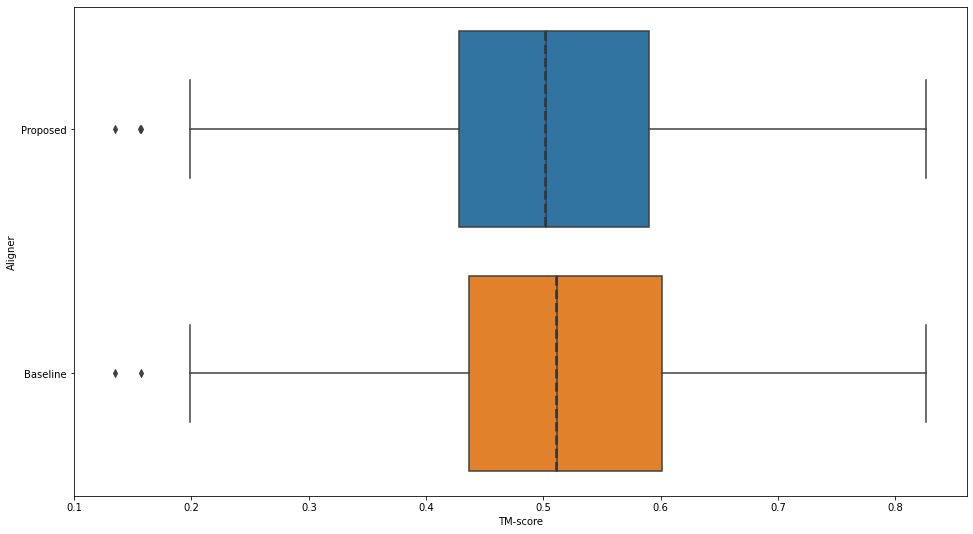

In [7]:
%matplotlib inline
import seaborn
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(16, 9))
seaborn.boxplot(x='TM-score', y='Aligner',
                data=new_hit_tmscore_df,
                ax=ax, showmeans=True, meanline=True, meanprops={'color': '#333333', 'linewidth': 2.5})

In [8]:
sw = new_hit_tmscore_df[new_hit_tmscore_df['Aligner'] == 'Baseline']
isw = new_hit_tmscore_df[new_hit_tmscore_df['Aligner'] == 'Proposed']
merged_df = pandas.merge(sw, isw, on='PDB')
merged_df['diff'] = merged_df['TM-score_y'] - merged_df['TM-score_x']
merged_df['Query'] = merged_df['PDB'].apply(lambda _: _[:7])
merged_df['Rank'] = merged_df['PDB'].apply(lambda _: int(_.split('_')[-1]))
merged_df = merged_df.sort_values('diff')
merged_df

,Aligner_x,Query_x,Template_x,TM-score_x,PDB,Aligner_y,Query_y,Template_y,TM-score_y,diff,Query,Rank
63,Baseline,d4a0yb_,d4k4ca_,0.80770,d4a0yb__28,Proposed,d4a0yb_,d4k4ca_,0.38542,-0.42228,d4a0yb_,28
85,Baseline,d1tp6a_,d1zo2a1,0.67971,d1tp6a__89,Proposed,d1tp6a_,d1zo2a1,0.31565,-0.36406,d1tp6a_,89
209,Baseline,d4pc3c1,d2crna1,0.63545,d4pc3c1_37,Proposed,d4pc3c1,d2crna1,0.43514,-0.20031,d4pc3c1,37
284,Baseline,d1tdja2,d2f06a2,0.64556,d1tdja2_20,Proposed,d1tdja2,d2f06a2,0.44716,-0.19840,d1tdja2,20
144,Baseline,d1w9aa_,d4l82a_,0.33081,d1w9aa__31,Proposed,d1w9aa_,d4l82a_,0.15617,-0.17464,d1w9aa_,31
...,...,...,...,...,...,...,...,...,...,...,...,...
141,Baseline,d1w9aa_,d4ybna_,0.63162,d1w9aa__18,Proposed,d1w9aa_,d4ybna_,0.65289,0.02127,d1w9aa_,18
109,Baseline,d2ux6a_,d2cbpa_,0.50077,d2ux6a__85,Proposed,d2ux6a_,d2cbpa_,0.52388,0.02311,d2ux6a_,85
277,Baseline,d1weoa1,d2mwxa_,0.34830,d1weoa1_30,Proposed,d1weoa1,d2mwxa_,0.37408,0.02578,d1weoa1,30
27,Baseline,d1k8rb_,d2al6a3,0.48744,d1k8rb__27,Proposed,d1k8rb_,d2al6a3,0.53126,0.04382,d1k8rb_,27


In [14]:
display(new_hit_tmscore_df[new_hit_tmscore_df['Aligner'] == 'Baseline'].describe())
display(new_hit_tmscore_df[new_hit_tmscore_df['Aligner'] == 'Proposed'].describe())

,TM-score
count,316.000000
mean,0.510630
std,0.126807
min,0.134370
25%,0.436775
50%,0.511915
75%,0.601495
max,0.826470


,TM-score
count,317.000000
mean,0.501190
std,0.126706
min,0.134370
25%,0.427710
50%,0.502460
75%,0.590490
max,0.826470


In [15]:
from scipy import stats
stats.ttest_rel(merged_df['TM-score_x'], merged_df['TM-score_y'])

Ttest_relResult(statistic=3.753756329566659, pvalue=0.00020739801418026286)

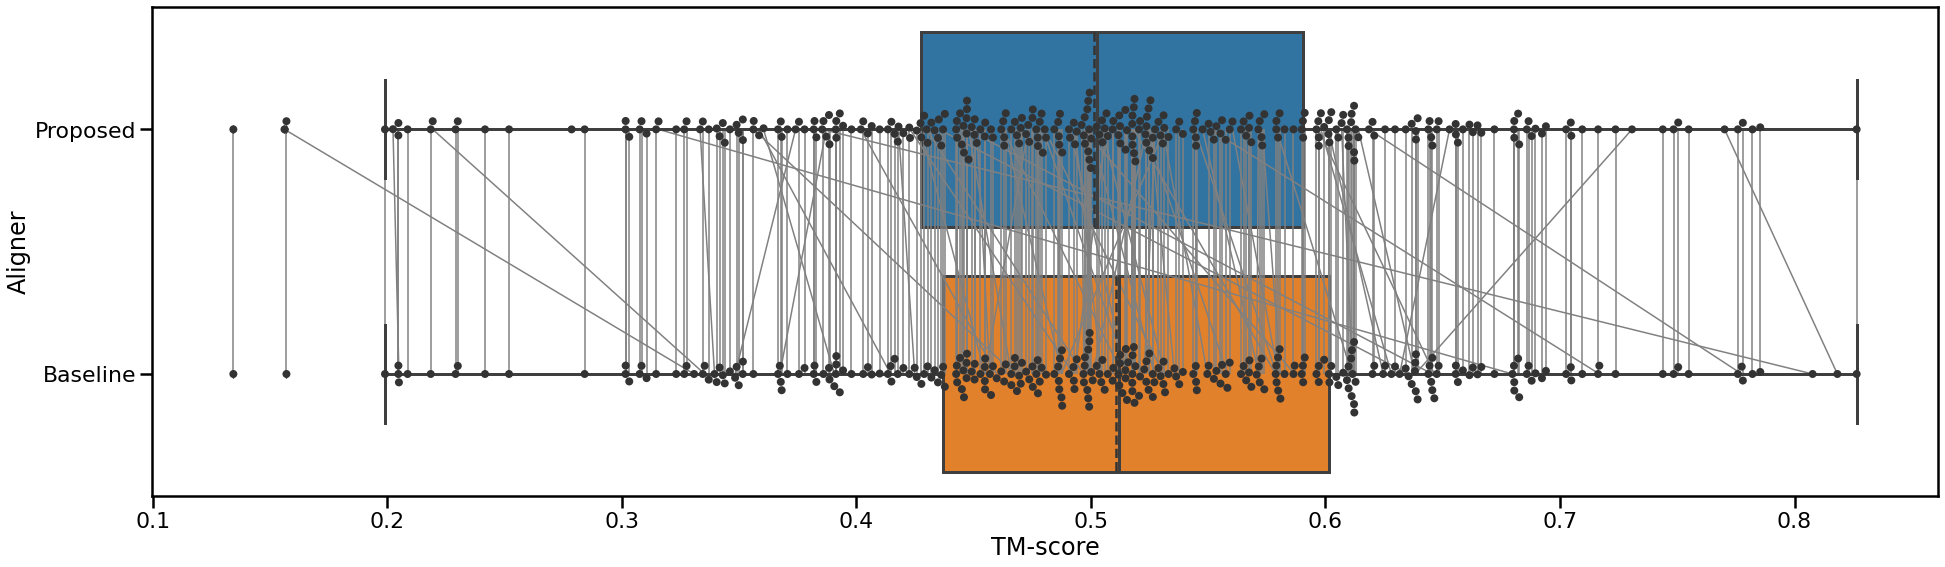

In [16]:
%matplotlib inline

from matplotlib import pyplot, collections
import seaborn

seaborn.set_context('poster')
fig, ax = pyplot.subplots(figsize=(32, 9))
seaborn.boxplot(x='TM-score', y='Aligner', data=new_hit_tmscore_df,
               showmeans=True, meanline=True, ax=ax, meanprops={'color': '#333333', 'linewidth': 2.5})
seaborn.swarmplot(x='TM-score', y='Aligner', data=new_hit_tmscore_df, color='0.2', size=8, ax=ax)
ax.add_collection(collections.LineCollection([[(_[1][3], 1), (_[1][8], 0)] for _ in merged_df.iterrows()], linewidths=1.5, colors='gray'))
#fig.savefig('img/hard_tm.pdf', bbox_inches='tight', pad_inches=0)